## **Network Visualization in Python ~ part 3**

This notebook was prepared by **Yessica Herrera-Guzmán** for the Network Science course at [Universidad del Desarrollo](https://www.udd.cl).

## **Part 3: Network connectivity**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import math
import csv
import community
import seaborn as sns
sns.set(context='notebook', style='ticks', font='Fira Sans', palette='husl', font_scale=1.2)

In [2]:
# Load nodelist
node_names = pd.read_csv('NYCBnodelist.csv') 

In [3]:
node_names.head(1)

,value,artist_type,gender
0,John Taras,Design,male


In [4]:
# Get a tuple with node names and their attributes
node_names['nodes'] = node_names[['value','artist_type', 'gender']].apply(tuple, axis=1)

In [5]:
node_tolist = node_names['nodes'].tolist()

In [6]:
# Creates nodelist
node_code = [n[0] for n in node_tolist]

In [7]:
# Load edgelist
edge_names = pd.read_csv('NYCBedgelist.csv') 

In [8]:
edge_names.head(1)

,source,target,type
0,Aaron Copland,April Gornik,1


In [9]:
# Get a tuple with node pairs (edges)
edge_names['edg'] = edge_names[['source', 'target']].apply(tuple, axis=1)

In [10]:
# Creates edgelist
edg = edge_names['edg'].tolist()

In [11]:
# Get a tuple with edge attributes
edge_names['edges'] = edge_names[['source', 'target', 'type']].apply(tuple, axis=1)

In [12]:
edge = edge_names['edges'].tolist()

**Network**

In [13]:
g = nx.Graph()

In [14]:
g.add_nodes_from(node_code)

In [15]:
g.add_edges_from(edg)

In [16]:
# Create dictionaire of node attribute: artist_type
gender_dict = {}

for node in node_tolist: 
    gender_dict[node[0]] = node[2]

In [17]:
nx.set_node_attributes(g, gender_dict, 'gender')

In [18]:
type_dict = {}

for e in edge: 
    type_dict[e[0], e[1]] = e[2]

In [19]:
nx.set_edge_attributes(g, type_dict, 'type')

In [20]:
# Remove self-loops
g.remove_edges_from(nx.selfloop_edges(g))

In [21]:
print(nx.info(g))

Graph with 549 nodes and 2202 edges


We will further process the network visualization using **Hierarchical Edge Bundling (HEB)** over the giant component of the network.

In [22]:
giant = g.subgraph(max(nx.connected_components(g), key=len))

In [23]:
degree_dict = dict(giant.degree(giant.nodes()))

In [24]:
import community
from cytoolz import keymap, keyfilter, valmap, valfilter, itemmap, frequencies

In [25]:
from networkx.algorithms.community import greedy_modularity_communities

In [26]:
nx.is_tree(giant)

False

In [27]:
subgraph_type = nx.get_edge_attributes(giant,'type')

In [28]:
dict_value_to_string = str(subgraph_type)

In [29]:
dendrogram = community.generate_dendrogram(giant, part_init=None, weight= dict_value_to_string, resolution=1, randomize=None, random_state=None)

In [30]:
communities = community.partition_at_level(dendrogram, len(dendrogram) - 1)

### **Hierarchies**

In [31]:
from networkx.drawing.nx_agraph import graphviz_layout

The code below was created from @zorzalerrante and can be found here: [uddvis](https://github.com/zorzalerrante/uddvis/blob/master/VISUDD_04_intro_redes.ipynb)

For more: [Datagramas](http://datagramas.cl)

In [32]:
community_structure = nx.DiGraph()

node_from_h = {}

dst_to_node = None

for level, comms in enumerate(dendrogram, start=0):
    if dst_to_node is None:
        src_to_node = {}
    else:
        src_to_node = dst_to_node
        
    dst_to_node = {}
    
    for src, dst in comms.items():
        if not src in src_to_node:
            src_node_id = community_structure.number_of_nodes()
            community_structure.add_node(src_node_id)
            src_to_node[src] = src_node_id
            
            node_from_h[src_node_id] = src
            
        if not dst in dst_to_node:
            dst_node_id = community_structure.number_of_nodes()
            community_structure.add_node(dst_node_id)
            dst_to_node[dst] = dst_node_id
            
        community_structure.add_edge(dst_to_node[dst], src_to_node[src])
        
root_node_id = community_structure.number_of_nodes()
community_structure.add_node(root_node_id)

for src, dst in dendrogram[-1].items():
    community_structure.add_edge(root_node_id, dst_to_node[dst])
    
community_structure.number_of_nodes(), community_structure.number_of_edges()

(669, 668)

In [33]:
nx.is_tree(giant)

False

In [34]:
nx.is_tree(community_structure)

True

In [35]:
hierarchical_pos = nx.drawing.nx_pydot.graphviz_layout(community_structure, prog='twopi', root=root_node_id)

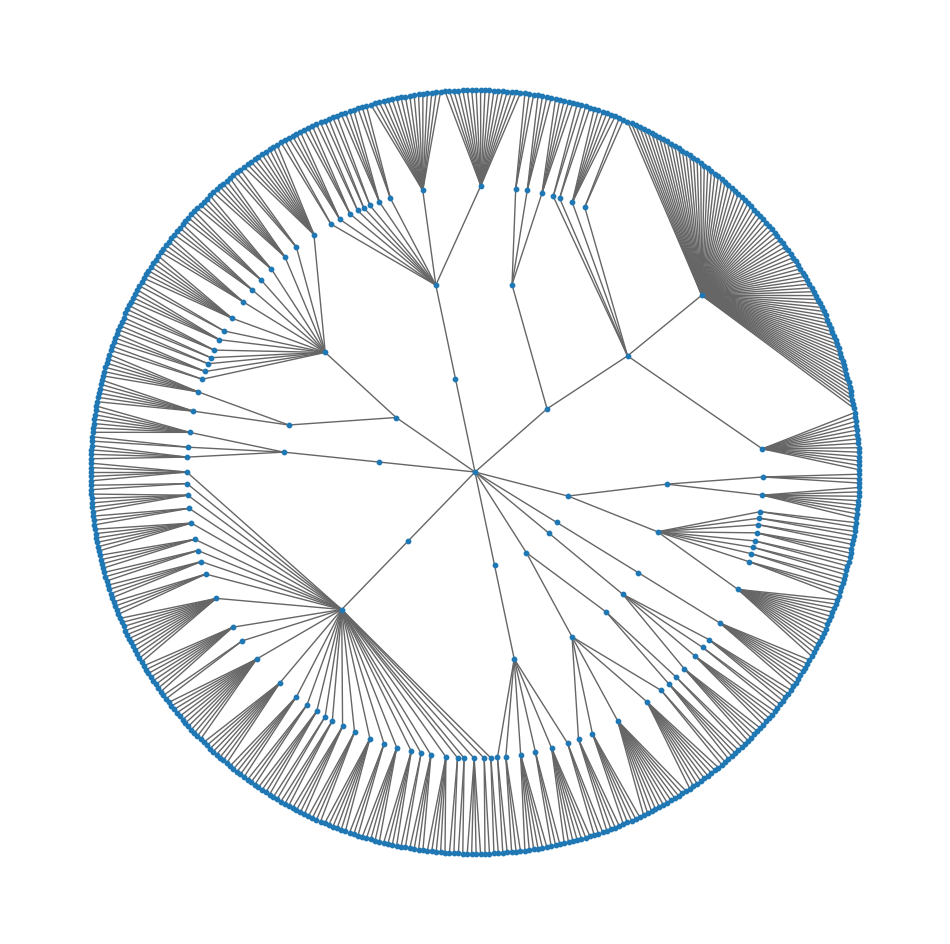

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(community_structure, with_labels=False, 
                 ax=ax, node_size=10, pos=hierarchical_pos, 
                 arrows=False, edge_color='#666666')
ax.set_axis_off()

In [37]:
circular_positions = keyfilter(lambda x: x in node_from_h, hierarchical_pos)
circular_positions = keymap(lambda x: node_from_h[x], circular_positions)
print(len(circular_positions), giant.number_of_nodes())

543 543


In [38]:
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors

In [39]:
# source: https://stackoverflow.com/questions/34803197/fast-b-spline-algorithm-with-numpy-scipy
import scipy.interpolate as si
import numpy as np

def scipy_bspline(cv, n=100, degree=3, periodic=False):
    """ Calculate n samples on a bspline

        cv :      Array ov control vertices
        n  :      Number of samples to return
        degree:   Curve degree
        periodic: True - Curve is closed
    """
    cv = np.asarray(cv)
    count = cv.shape[0]

    # Closed curve
    if periodic:
        kv = np.arange(-degree,count+degree+1)
        factor, fraction = divmod(count+degree+1, count)
        cv = np.roll(np.concatenate((cv,) * factor + (cv[:fraction],)),-1,axis=0)
        degree = np.clip(degree,1,degree)

    # Opened curve
    else:
        degree = np.clip(degree,1,count-1)
        kv = np.clip(np.arange(count+degree+1)-degree,0,count-degree)

    # Return samples
    max_param = count - (degree * (1-periodic))
    spl = si.BSpline(kv, cv, degree)
    return spl(np.linspace(0,max_param,n))

In [40]:
node_to_h = itemmap(reversed, node_from_h)
community_structure_undirected = community_structure.to_undirected()

def edge_to_spline(src, dst, n_points=100, smoothing_factor=0.8):
    edge_path = nx.shortest_path(community_structure_undirected, node_to_h[src], node_to_h[dst])
    edge_cp = [hierarchical_pos[node_id] for node_id in edge_path]
    
    try:    
        smooth_edge = scipy_bspline(edge_cp, degree=min(len(edge_cp) - 1, 3), n=n_points)
        source_edge = np.vstack((np.linspace(edge_cp[0][0], edge_cp[-1][0], num=n_points, endpoint=True),
                                 np.linspace(edge_cp[0][1], edge_cp[-1][1], num=n_points, endpoint=True))).T
        
        if smoothing_factor < 1.0:
            smooth_edge = smooth_edge * smoothing_factor + source_edge * (1.0 - smoothing_factor)
        
        return smooth_edge
    except ValueError:
        print(src, dst, 'error')
        return None

In [41]:
edge_lines = []
smoothing_factor = 0.75
# resolución de cada arista en vértices. más puntos, mejor calidad de imagen, pero más tiempo de cálculo y de dibujo.
n_points = 50

for src, dst in giant.edges():    
    edge_lines.append(edge_to_spline(src, dst, 
                                     n_points=n_points, 
                                     smoothing_factor=smoothing_factor))

**Visualize network connections by gender**

In [42]:
# Create color dictionare for nodes by their gender
node_gender = []

# for each node in the graph
for node in giant.nodes(data=True):

    # if the node has the attribute group1
    if 'female' in node[1]['gender']:
        node_gender.append('#e377c2') # female, pink

    # if the node has the attribute group1
    elif 'male' in node[1]['gender']:
        node_gender.append('#17becf') # male, blue
        
    # if the node has the attribute group1
    elif 'various' in node[1]['gender']:
        node_gender.append('#bcbd22') # mixed, yellow
        
    # if the node has the attribute group1
    elif 'unknown' in node[1]['gender']:
        node_gender.append('#7f7f7f') # mixed, gray

In [43]:
# Create color dictionare for edges by their type
edge_color = []

for e in giant.edges():
    edge_type = giant[e[0]][e[1]]['type']
    
    if edge_type == 1:
        edge_color.append('#7f7f7f') # mixed
    elif edge_type == 2:
        edge_color.append('#e377c2')  # woman - woman
    elif edge_type == 3:
        edge_color.append('#17becf') # man - man

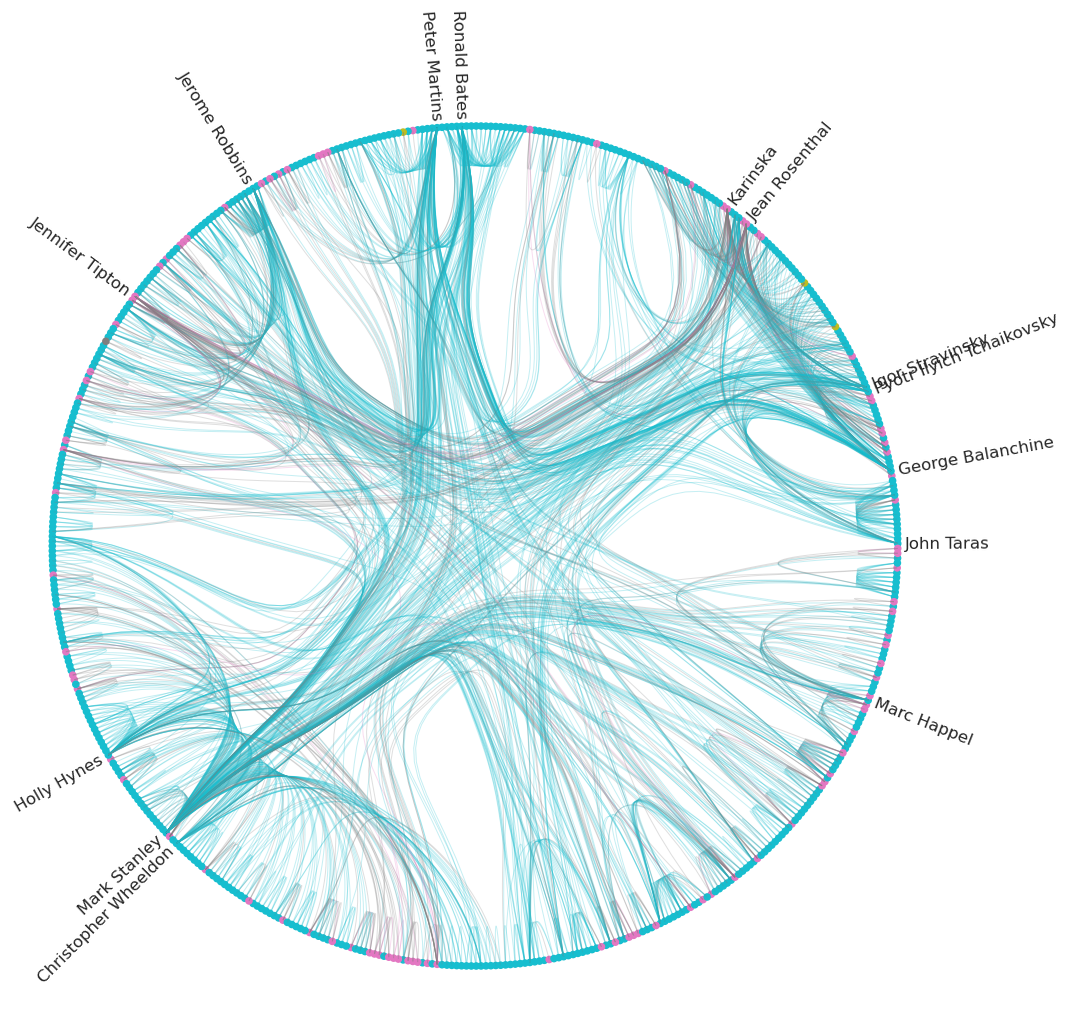

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# aquí dibujamos la red con HEB
nx.draw_networkx_nodes(giant, ax=ax, pos=circular_positions, 
                 node_color=node_gender,
                 node_size=20)

edge_collection = LineCollection(edge_lines, color=edge_color, 
                                 linewidth=0.7, linestyle='solid', 
                                 alpha=0.25)
plt.gca().add_collection(edge_collection)

# ahora agregaremos los nombres de las personas
# necesitamos orientarlas respecto al centroide de la visualización
centroid = np.mean(list(circular_positions.values()), axis=0)

# para cada nodo calcularemos la posición y el ángulo de su etiqueta
for node_id, pos in circular_positions.items():
    if degree_dict[node_id] < 40:
        
        continue 
    # posición del nodo
    pos = np.array(pos)
    # vector desde el centro hasta el nodo
    vec = pos - centroid
    # distancia desde el centro en la que aparecerá la etiqueta, con un espacio extra en blanco
    length = np.sqrt(vec.dot(vec)) + 5
    # vector unitario en dirección del texto
    vec = vec / length
    # ángulo determinado por el vector
    angle = np.arctan2(vec[1], vec[0])
    
    # ¿cómo orientaremos el texto? 
    va = 'center'
    
    if vec[0] >= 0:
        ha = 'left'
    else:
        ha = 'right'
    
    text_rotation = np.rad2deg(angle)
    
    if text_rotation > 90:
        text_rotation = text_rotation - 180
    elif text_rotation < -90:
        text_rotation = text_rotation + 180
        
    # con esto agregamos el texto a la visualización
    plt.annotate('{}'.format(node_id), 
                 (centroid[0] + length * np.cos(angle), centroid[1] + length * np.sin(angle)), 
                 rotation=text_rotation, ha=ha, va=va, rotation_mode='anchor',
                 fontsize='small')
    
#ax.set_title('Ballet Network Communities, top degree', y=1.05)
ax.set_axis_off()

Quick excercise:

1. Use eigenvector centrality to identify the most influential nodes. Who are the most influential nodes in the network?
2. What can you learn about the flow of connections at the New York City Ballet from this visualization?
3. Summarize your learning by discussing what are the features of each visualization and in which contexts of network research these are more convenient to use. 